In [1]:
%%javascript
$.getScript('http://homes.esat.kuleuven.be/~mjuarezm/ipy_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [15]:
# ipy imports
%matplotlib inline
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell

# Notebook config
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# button to toggle code
HTML('''<form action="javascript:code_toggle()">
            <input type="submit" value="Toggle cells.">
        </form>
     ''')

# Introduction

The objective of this analysis is to study the distribution of network jitter in Tor nodes. Some nodes might have a significantly large jitter than the average. We believe that in those cases, website fingerprinting may have lower effectiveness than in the nodes with low jitter. The rationale is that even if the Tor path is independent of the website, the interaction between the page structure (HTTP request/response pattern) and the jitter, may make the fingerprint less reliable than in high-jitter paths.

In [4]:
import re
from os import listdir
from os.path import join, dirname, realpath, isdir, getmtime, splitext
from glob import glob

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

# directories
BASE_DIR = dirname(realpath("__file__"))
RESULTS_DIR = join(BASE_DIR, 'results')
LATEST_FILE = max([join(RESULTS_DIR, d) for d in listdir(RESULTS_DIR)], key=getmtime)
LATEST_DATA = '%s.csv' % splitext(LATEST_FILE)[0]

In [5]:
# URLs
ATLAS = '<a href="https://atlas.torproject.org/#details/{fp}" target="_blank">{fp}</a>'

def fp2url(df):
    """Convert node fingerprints to links to Tor Atlas."""
    fp_re = re.compile(r"([A-F0-9]{40})", re.MULTILINE | re.UNICODE)
    def repl_fp(match):
        match = match.group()
        return ATLAS.format(fp=match)
    return fp_re.sub(repl_fp, df.to_html())

# Collected data


For our data collection, we make a TCP connection to the node's OR port and record all the traffic that is generated. In total, we have collected:

In [6]:
# load data
data = pd.read_csv(join(LATEST_DATA))

num_samples = len(data)
print "- Total num samples:", num_samples

nodes = data.groupby(['fp'])['fp'].count()
num_nodes = len(nodes)
print "- Found data for", num_nodes, "nodes"

avg_num_samples_per_nodes = nodes.mean()
print "- An average of", int(avg_num_samples_per_nodes), "samples for each node."

- Total num samples: 1576222
- Found data for 6754 nodes
- An average of 233 samples for each node.


This is how the dataset looks like:

In [37]:
# load data in a dataframe
data[:20]

,sample_id,fp,flags,latency
0,71129060,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.214820
1,71129061,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.194509
2,71129072,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.181540
3,71129083,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.181521
4,71129084,000A10D43011EA4928A35F610405F92B4433B4DC,Running Stable Valid,0.193479
5,71129050,000DC6DAF1CDB24879401E549F969FC72C1D690D,Fast Running V2Dir Valid,0.073185
6,71129051,000DC6DAF1CDB24879401E549F969FC72C1D690D,Fast Running V2Dir Valid,0.034997
7,71129062,000DC6DAF1CDB24879401E549F969FC72C1D690D,Fast Running V2Dir Valid,0.028168
8,71129063,000DC6DAF1CDB24879401E549F969FC72C1D690D,Fast Running V2Dir Valid,0.041186
9,71129074,000DC6DAF1CDB24879401E549F969FC72C1D690D,Fast Running V2Dir Valid,0.041439


# Latency

From the traffic traces collected for the TCP connections to the nodes, we extract the first SYN+ACK packet (if any) and its corresponding SYN packet. Next, we substract the SYN timestamp to the SYN+ACK timestamp to obtain a measurement of the latency to a node.

We extract some basic statistics about the latencies:

In [ ]:
data['latency'].describe()

In [39]:
# group by each five samples
data.sample_id.to_string().str[:-2]

AttributeError: 'unicode' object has no attribute 'str'

In [33]:
data[['flags', 'latency']].plot(by='flags', kind='hist', ax=ax1, figsize=(10, 3), title="Node mean latency")

We plot the histogram of latencies:

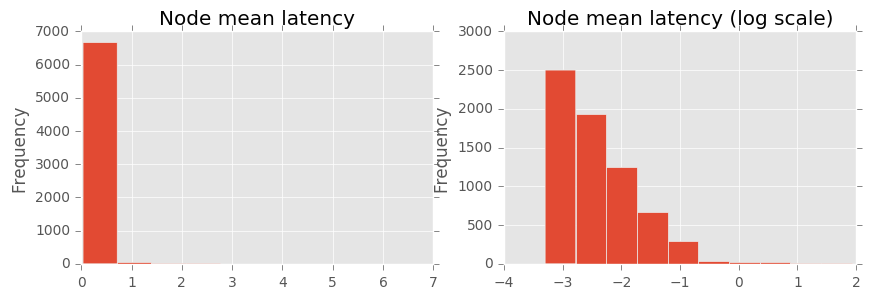

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
mean_latencies = data.groupby(['fp']).latency.mean().reset_index(name='mean_latency')
mean_latencies['mean_latency'].plot(kind='hist', ax=ax1, figsize=(10, 3), title="Node mean latency");
mean_latencies['mean_latency'].apply(np.log).plot(kind='hist', ax=ax2, figsize=(10, 3), title="Node mean latency (log scale)");

Top nodes by average latency:

In [11]:
top_lat = mean_latencies.sort_values(['mean_latency'], ascending=False).head()
HTML(fp2url(top_lat))

,fp,mean_latency
3201,7C288587BA0D99CC6B8537CDC2C4639FA827B907,6.835259
3146,79CF377F0ACEC5F0002D85335E4192B34202A269,6.831084
1159,2C804AAB0C02F971A4386B3A1F2AC00F9E080679,6.540562
2561,615EBC4B48F03858FA50A3E23E5AF569D0D2308A,6.216942
1135,2B44FD1742D26E4F28D4CACF1F0CF8A686270E45,6.038559


# Jitter

We measure jitter of a node as the variance of the node's latency. We can calculate the variance because we take several samples for each node.

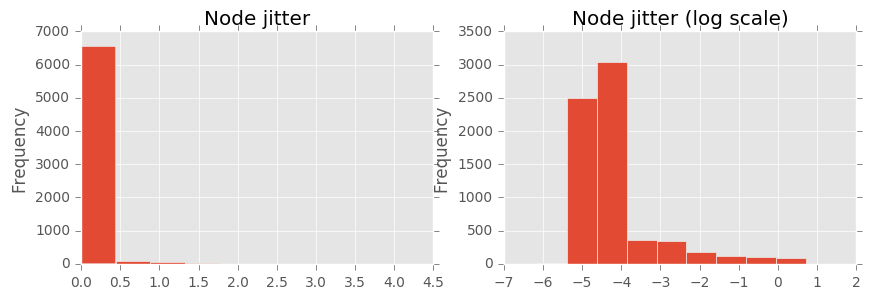

In [12]:
# compute jitter
jitters = data.groupby(['fp']).latency.std().reset_index(name='jitter')
node_stats = pd.merge(mean_latencies, jitters, on='fp')

# plot histograms
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
node_stats['jitter'].plot(kind='hist', ax=ax1, figsize=(10, 3), title="Node jitter");
node_stats['jitter'].apply(np.log).plot(kind='hist', ax=ax2, figsize=(10, 3), title="Node jitter (log scale)");

Top nodes by jitter:

In [13]:
top_jitter = node_stats.sort_values(['jitter'], ascending=False).head()
HTML(fp2url(top_jitter))

,fp,mean_latency,jitter
1648,3E63C02AF773DEA5341A028AA1FD48ADFB348410,4.647023,4.396737
5466,D0029D653FC0A6F026C5E61938A15E10478B6395,1.063120,2.524396
4907,BC5C4B2D0DB36540A59DCA72BB75C98DE76F72BF,3.136190,2.446073
6745,FFB8575D7C8E40AC6E48C1B7AA32AC7701E04AB9,1.504014,2.104946
4194,A20840A16CB658024B0D3A0E3F19A9C0E34C843F,0.706318,2.049198
